This notebook demonstrates Poisson reduced-rank regression (p-RRR) on a synthetic dataset. It should take less than 5mins to run the entire notebook.

In [1]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn.metrics
from tabulate import tabulate

In [2]:
from poisson_rrr import *
from linear_rrr import *

# Create synthetic dataset

Let $Y \sim Poisson(\lambda)$, where $\lambda = f(XW+b)$, $rank(W) = R$. Here we use $f(z) = \log (1+e^z)$ (the softplus function).

Dimensions: 

$X: X_0 \times X_1$

$Y: X_0 \times Y_1$

$W: X_1 \times Y_1$, $rank(W) = R \leq \min(X_1, Y_1)$

$b: 1 \times Y_1$

In [3]:
seed = 1
rng = np.random.default_rng(seed=seed)
X0 = int(1e+4)
X1 = int(100)
Y1 = int(50)
R = 10

In [4]:
X = rng.normal(size=(X0, X1))

In [5]:
W = rng.normal(size=(X1, Y1))

# make rank(W)=rank
u, s, vh = np.linalg.svd(W, full_matrices=False)
print(u.shape, s.shape, vh.shape)
s0 = s[:R]
smat = np.diag(s0)
W = np.dot(u[:,:R], np.dot(smat, vh[:R]))

(100, 50) (50,) (50, 50)


In [6]:
print(W.shape, np.linalg.matrix_rank(W))

(100, 50) 10


In [7]:
b = rng.normal(size=(Y1))
print(b.shape)

(50,)


In [8]:
M = X @ W + b
Y_mean = F.softplus(torch.from_numpy(M).float())

In [9]:
Y = rng.poisson(Y_mean.numpy())
print(Y.shape)

(10000, 50)


In [10]:
X_train, Y_train = X[:int(X0*0.8)], Y[:int(X0*0.8)]
X_test, Y_test = X[int(X0*0.8):], Y[int(X0*0.8):]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(8000, 100) (2000, 100) (8000, 50) (2000, 50)


# Model fitting

In [17]:
pRRR = PoissonRRR(n_input=X1, 
                  n_output=Y1, 
                  act='softplus', 
                  rank=10, 
                  loss='poisson',
                  regList=[0], 
                  zeromeanXs=[0], 
                  normstdXs=[0], 
                  seed=1)

In [18]:
start = time.time()
train_loss_hist, grad_hist = pRRR.train([X_train], 
                                           Y_train, 
                                           lr=1, 
                                           maxepoch=50, 
                                           max_iter=20,
                                           history_size=10, 
                                           line_search=1,
                                           grad_tol=1e-4, 
                                           loss_tol=1e-6, 
                                           patience=10, 
                                           shuffle=True, 
                                           track=1, 
                                           progfile=None)
end = time.time()
print('elapsed {:.4f}s'.format(end-start))

train: cpu
epoch 0: training loss 
 5.392459869384766
epoch 1: training loss 1.1938259601593018
          gradient [0.00201149 0.00292965 0.0037921  0.00191874]
epoch 2: training loss 1.177224040031433
          gradient [3.0653460e-05 6.2797269e-05 5.9043174e-05 1.0294747e-04]
gradient less than 0.0001 after 3 epochs 
 
epoch 3: training loss 1.1771981716156006
          gradient [3.4254743e-05 2.2503140e-05 6.3393665e-05 2.3236458e-05]
final train loss 1.177198 grad [3.4254743e-05 2.2503140e-05 6.3393665e-05 2.3236458e-05] 

elapsed 1.0419s


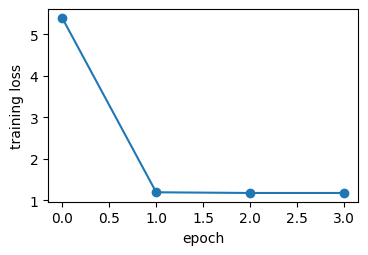

In [19]:
fig, ax = plt.subplots(figsize=(4, 2.5))
plt.plot(train_loss_hist, '-o')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

Poisson-RRR is optimized with L-BFGS, which converges super fast compared to gradient descent!

Test set prediction

In [20]:
test_scores, Y_test_pred = pRRR.eval([X_test], Y_test, metrics=['PNLL', 'cc', 'r2', 'd2'])

cpu


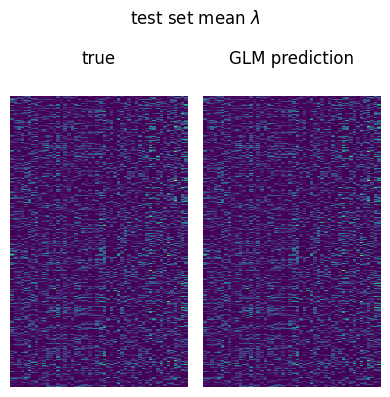

In [21]:
fig, (ax1, ax2) =  plt.subplots(1, 2, figsize=(4, 4))
ax1.matshow(Y_mean.numpy()[int(X0*0.8):], aspect='auto')
ax1.axis('off')
ax1.set_title('true')

ax2.matshow(Y_test_pred, aspect='auto')
ax2.axis('off')
ax2.set_title('GLM prediction')

fig.suptitle('test set mean $\lambda$')
plt.tight_layout()
plt.show()

Parameters recovery

In [22]:
W_hat = (pRRR.glm.state_dict()['linear2.weight'].detach().numpy() @ pRRR.glm.state_dict()['linear1.weight'].detach().numpy()).transpose()
print(W_hat.shape)
b_hat = pRRR.glm.state_dict()['linear2.weight'].detach().numpy() @pRRR.glm.state_dict()['linear1.bias'].detach().numpy().reshape((-1, 1)) + pRRR.glm.state_dict()['linear2.bias'].detach().numpy().reshape((-1, 1))
print(b_hat.shape)

(100, 50)
(50, 1)


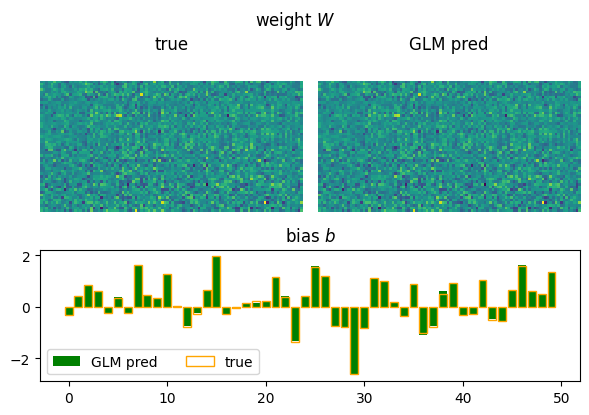

In [23]:
fig, axes = plt.subplot_mosaic([["top left", "top right"], ["bottom row", "bottom row"]], figsize=(6, 4))

fig.text(0.5, 1, r'weight $W$', ha='center', va='center', fontsize='large')
axes["top left"].matshow(W.T, aspect='auto')
axes["top left"].axis('off')
axes["top left"].set_title('true')

axes["top right"].matshow(W_hat.T, aspect='auto')
axes["top right"].axis('off')
axes["top right"].set_title('GLM pred')

axes["bottom row"].bar(x=np.arange(Y1), height=b_hat.ravel(), color='green', label='GLM pred')
axes["bottom row"].bar(x=np.arange(Y1), height=b, color='None', edgecolor='orange', label='true')

axes["bottom row"].legend(ncol=2)
axes["bottom row"].set_title(r'bias $b$')

plt.tight_layout()
plt.show()

Latent factors recovery (here latent factors are defined as $U\Sigma$ if $W$ has SVD $W=U\Sigma V^T$) 

In [24]:
u_true, s_true, vh_true = np.linalg.svd(W, full_matrices=False)
print(u_true.shape, s_true.shape, vh_true.shape)

(100, 50) (50,) (50, 50)


In [25]:
u_hat, s_hat, vh_hat = np.linalg.svd(W_hat, full_matrices=False)

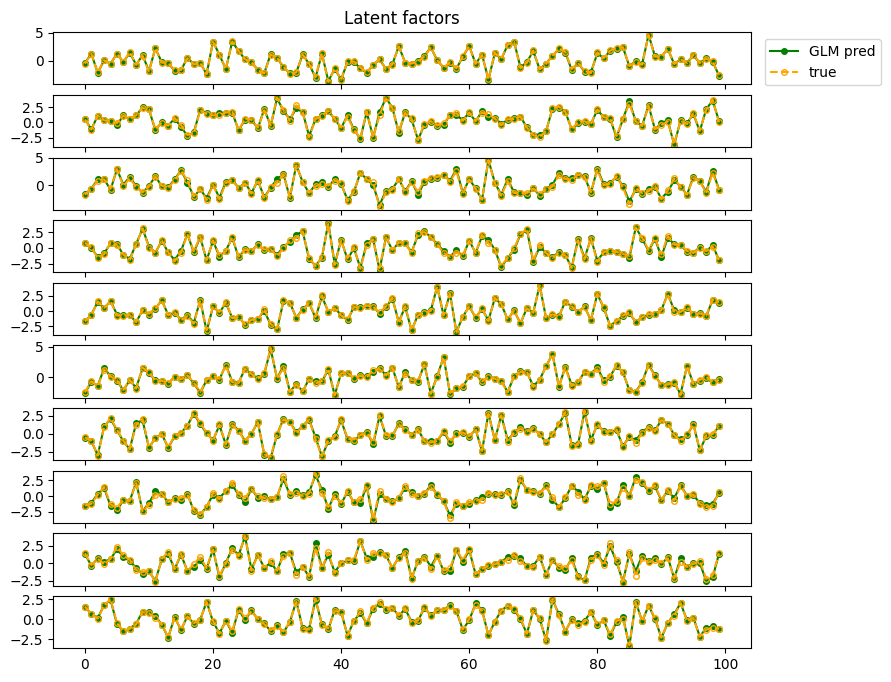

In [26]:
fig, axes = plt.subplots(R, 1, sharex=True, figsize=(9, 8))
for i in range(R):
    angle = np.dot(u_true[:,i], u_hat[:,i])/(np.linalg.norm(u_true[:,i])*np.linalg.norm(u_hat[:,i]))
    if angle > 0:
        axes[i].plot(u_hat[:,i]*s_hat[i], '-o', markersize=4, color='green', label='GLM pred')
    else:
        axes[i].plot(-u_hat[:,i]*s_hat[i], '-o', markersize=4, color='green', label='GLM pred')
    
    axes[i].plot(u_true[:,i]*s_true[i], '--o', markersize=4, color='orange', markerfacecolor='None', label='true')
axes[0].legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
axes[0].set_title('Latent factors')

plt.show()

# Rank selection

In [48]:
ranks = [1, 2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 40, 50]
regs = [0, 1e-6, 1e-5, 1e-4, 1e-3]

To find the optimal rank and regularization parameter, split the training data into 2 halves to do a 2-fold cross-validation (will take ~ 3 minutes). 


In [49]:
train_size = X0*0.8
X_train1, Y_train1 = X_train[:int(train_size//2)], Y_train[:int(train_size//2)]
X_val1, Y_val1 = X_train[int(train_size//2):], Y_train[int(train_size//2):]

In [50]:
PNLL_cv_2fold = np.zeros((2, len(ranks), len(regs)))
d2_cv_2fold = np.zeros((2, len(ranks), len(regs)))

print('total settings', len(ranks)*len(regs))
for i, rank in enumerate(ranks):
    for j, reg in enumerate(regs):
        print('-----------------------')
        print('setting', i*len(regs)+j)
        pRRR0 = PoissonRRR(n_input=X1, n_output=Y1, act='softplus', rank=rank, loss='poisson', zeromeanXs=[0], normstdXs=[0], regList=[reg], seed=1)
        train_loss_hist, grad_hist = pRRR0.train([X_train1], Y_train1, lr=1, maxepoch=50, max_iter=20,
                                          history_size=10, grad_tol=1e-4, line_search=1,
                                          shuffle=True, track=1, patience=10, loss_tol=1e-6, progfile=None)
        test_scores, Y_test_pred = pRRR0.eval([X_val1], Y_val1, metrics=['PNLL', 'd2'])
        PNLL_cv_2fold[0, i, j] = test_scores['PNLL']
        d2_cv_2fold[0, i, j] = test_scores['d2uniform']
        
        pRRR1 = PoissonRRR(n_input=X1, n_output=Y1, act='softplus', rank=rank, loss='poisson', zeromeanXs=[0], normstdXs=[0], regList=[reg], seed=1)
        train_loss_hist, grad_hist = pRRR1.train([X_val1], Y_val1, lr=1, maxepoch=50, max_iter=20,
                                          history_size=10, grad_tol=1e-4, line_search=1,
                                          shuffle=True, track=1, patience=10, loss_tol=1e-6, progfile=None)
        test_scores, Y_test_pred = pRRR1.eval([X_train1], Y_train1, metrics=['PNLL', 'd2'])
        PNLL_cv_2fold[1, i, j] = test_scores['PNLL']
        d2_cv_2fold[1, i, j] = test_scores['d2uniform']


total settings 65
-----------------------
setting 0
train: cpu
epoch 0: training loss 
 5.553553581237793
epoch 1: training loss 3.2499749660491943
          gradient [0.00163647 0.00144429 0.00201872 0.00177887]
epoch 2: training loss 3.2284414768218994
          gradient [0.00084231 0.00036289 0.00306217 0.00093616]
epoch 3: training loss 3.2256999015808105
          gradient [0.00014824 0.00027975 0.00090269 0.0002501 ]
epoch 4: training loss 3.2255496978759766
          gradient [8.3805877e-05 7.1625516e-05 1.2574560e-04 6.9683971e-05]
gradient less than 0.0001 after 5 epochs 
 
epoch 5: training loss 3.225536584854126
          gradient [2.4073670e-05 2.1078886e-05 3.9123595e-05 2.9180730e-05]
final train loss 3.225537 grad [2.4073670e-05 2.1078886e-05 3.9123595e-05 2.9180730e-05] 

cpu
train: cpu
epoch 0: training loss 
 5.530197620391846
epoch 1: training loss 3.240856647491455
          gradient [0.00160085 0.00279658 0.00210535 0.00218849]
epoch 2: training loss 3.211380720138

epoch 1: training loss 2.988116502761841
          gradient [0.00088887 0.00074033 0.00125084 0.00168396]
epoch 2: training loss 2.9796159267425537
          gradient [0.00084508 0.00061828 0.00177938 0.00069278]
epoch 3: training loss 2.9755828380584717
          gradient [0.00063484 0.00067064 0.0028409  0.00058902]
epoch 4: training loss 2.9724392890930176
          gradient [0.00052292 0.00025013 0.00131566 0.00031382]
epoch 5: training loss 2.9716103076934814
          gradient [1.7382161e-04 9.4390125e-05 8.7694434e-04 2.5929936e-04]
epoch 6: training loss 2.9713308811187744
          gradient [2.0874098e-04 5.5782992e-05 7.0950686e-04 1.6449233e-04]
epoch 7: training loss 2.970018148422241
          gradient [0.00066398 0.0006369  0.00175197 0.00047842]
epoch 8: training loss 2.9686360359191895
          gradient [0.0002098  0.00034937 0.00140697 0.00050594]
epoch 9: training loss 2.968162775039673
          gradient [1.7389946e-04 7.2934694e-05 2.8499530e-04 1.7129839e-04]
epoc

epoch 1: training loss 2.562457323074341
          gradient [0.00229094 0.00287653 0.0087311  0.00220644]
epoch 2: training loss 2.514477491378784
          gradient [0.00090091 0.00061637 0.00246249 0.00117878]
epoch 3: training loss 2.508622407913208
          gradient [0.00066315 0.000473   0.00148844 0.00083583]
epoch 4: training loss 2.5016567707061768
          gradient [0.00041271 0.00035552 0.00206462 0.00137558]
epoch 5: training loss 2.4983437061309814
          gradient [0.00039876 0.00025379 0.00303856 0.00056086]
epoch 6: training loss 2.497011661529541
          gradient [0.00011994 0.0002664  0.00141769 0.00020716]
epoch 7: training loss 2.496788740158081
          gradient [7.2285147e-05 4.8092003e-05 2.1849078e-04 8.5765052e-05]
epoch 8: training loss 2.496744155883789
          gradient [2.6615742e-05 1.0050786e-05 1.5466439e-04 4.3592685e-05]
epoch 9: training loss 2.4967377185821533
          gradient [1.7015083e-05 4.3384687e-05 1.6813475e-04 3.4229335e-05]
gradien

epoch 1: training loss 2.7530581951141357
          gradient [0.00215249 0.0024946  0.01798773 0.00309353]
epoch 2: training loss 2.7145588397979736
          gradient [0.00075575 0.00052516 0.00130859 0.00107034]
epoch 3: training loss 2.706402063369751
          gradient [0.00058187 0.00029993 0.00153178 0.00064412]
epoch 4: training loss 2.698169231414795
          gradient [0.00042372 0.00011964 0.00058037 0.00055403]
epoch 5: training loss 2.6966989040374756
          gradient [0.00010931 0.00011576 0.00036878 0.00012466]
gradient less than 0.0001 after 6 epochs 
 
epoch 6: training loss 2.69661545753479
          gradient [2.5586691e-05 5.5391574e-06 4.5306195e-05 2.8055591e-05]
train: cpu
epoch 0: training loss 
 5.389870643615723
epoch 1: training loss 2.730142831802368
          gradient [0.0014096  0.00137065 0.00627552 0.00181448]
epoch 2: training loss 2.7112226486206055
          gradient [0.00052674 0.00040838 0.0025219  0.00080326]
epoch 3: training loss 2.70390510559082

epoch 2: training loss 1.6088385581970215
          gradient [0.00026862 0.00013364 0.00085403 0.00052042]
epoch 3: training loss 1.6077417135238647
          gradient [6.5451357e-05 6.9723348e-05 6.1438687e-04 1.0959132e-04]
epoch 4: training loss 1.6076241731643677
          gradient [4.7791124e-05 4.5378496e-05 1.0359257e-04 1.2867269e-04]
gradient less than 0.0001 after 5 epochs 
 
epoch 5: training loss 1.6075105667114258
          gradient [1.9395608e-05 1.0562799e-05 5.7090190e-05 3.1157429e-05]
train: cpu
epoch 0: training loss 
 5.397936820983887
epoch 1: training loss 1.6268024444580078
          gradient [0.00199816 0.00190874 0.00891676 0.00154284]
epoch 2: training loss 1.6035563945770264
          gradient [0.0002802  0.0005181  0.00220231 0.00068571]
epoch 3: training loss 1.6014233827590942
          gradient [1.3056323e-04 9.8703473e-05 5.2000606e-04 1.8701042e-04]
epoch 4: training loss 1.6011803150177002
          gradient [4.0931867e-05 5.5366108e-05 2.2194441e-04 1

epoch 1: training loss 1.1889482736587524
          gradient [0.00108628 0.00356349 0.00279426 0.00142853]
epoch 2: training loss 1.1761372089385986
          gradient [6.8749032e-05 5.5875942e-05 1.7761441e-04 1.2479254e-04]
gradient less than 0.0001 after 3 epochs 
 
epoch 3: training loss 1.1761101484298706
          gradient [4.0120626e-06 4.7086487e-06 2.8629376e-05 2.2181841e-05]
train: cpu
epoch 0: training loss 
 5.382192611694336
epoch 1: training loss 1.1902433633804321
          gradient [0.00239738 0.00366183 0.00398841 0.00172058]
epoch 2: training loss 1.1757959127426147
          gradient [3.1824729e-05 6.4286374e-05 1.6131486e-04 1.1019048e-04]
gradient less than 0.0001 after 3 epochs 
 
epoch 3: training loss 1.1757688522338867
          gradient [1.1642967e-05 8.3388368e-06 5.8147903e-05 1.1078836e-05]
-----------------------
setting 27
train: cpu
epoch 0: training loss 
 5.40272855758667
epoch 1: training loss 1.1988290548324585
          gradient [0.00096099 0.00595

epoch 2: training loss 1.2197198867797852
          gradient [6.2833155e-05 1.0321665e-04 5.2973494e-04 7.6558652e-05]
epoch 3: training loss 1.2194819450378418
          gradient [4.234721e-05 5.132986e-05 3.680037e-04 5.530536e-05]
epoch 4: training loss 1.2194249629974365
          gradient [3.8885351e-05 6.5222521e-05 1.5082261e-04 1.6409238e-05]
gradient less than 0.0001 after 5 epochs 
 
epoch 5: training loss 1.2193975448608398
          gradient [1.2047394e-05 1.0269017e-05 3.6606594e-05 1.0728863e-05]
-----------------------
setting 34
train: cpu
epoch 0: training loss 
 5.419529438018799
epoch 1: training loss 1.5838611125946045
          gradient [1.1623156e-04 1.3190275e-04 2.4591835e-04 9.2423099e-05]
epoch 2: training loss 1.583189845085144
          gradient [7.2052586e-05 5.7880803e-05 1.7042062e-04 5.2297764e-05]
epoch 3: training loss 1.583007574081421
          gradient [6.1727420e-05 7.7498102e-05 2.0965317e-04 2.9336639e-05]
gradient less than 0.0001 after 4 epochs

epoch 1: training loss 1.173059105873108
          gradient [0.00017805 0.00036192 0.00056169 0.0001311 ]
epoch 2: training loss 1.1711455583572388
          gradient [9.5206298e-05 1.0035669e-04 2.9281192e-04 8.3288032e-05]
epoch 3: training loss 1.1705636978149414
          gradient [4.1638978e-05 1.2897707e-04 1.3805073e-04 5.1324012e-05]
epoch 4: training loss 1.170438289642334
          gradient [2.6499678e-05 6.1591796e-05 1.1981893e-04 3.6556219e-05]
gradient less than 0.0001 after 5 epochs 
 
epoch 5: training loss 1.1703968048095703
          gradient [1.3547690e-05 2.5528912e-05 2.7084818e-05 9.0248141e-06]
-----------------------
setting 41
train: cpu
epoch 0: training loss 
 5.443387031555176
epoch 1: training loss 1.1737347841262817
          gradient [0.00024638 0.00035235 0.00043552 0.00016431]
epoch 2: training loss 1.172096610069275
          gradient [8.4762672e-05 1.7922789e-04 3.5272576e-04 8.6766406e-05]
epoch 3: training loss 1.1715511083602905
          gradient 

gradient less than 0.0001 after 4 epochs 
 
epoch 4: training loss 1.1745340824127197
          gradient [2.9341485e-05 2.9522074e-05 8.4687934e-05 2.4062701e-05]
train: cpu
epoch 0: training loss 
 5.391260623931885
epoch 1: training loss 1.1777747869491577
          gradient [0.00019236 0.00026211 0.00079039 0.00015668]
epoch 2: training loss 1.1749904155731201
          gradient [9.9147488e-05 1.7554607e-04 2.9120417e-04 6.8713583e-05]
epoch 3: training loss 1.1742887496948242
          gradient [5.8477934e-05 1.6541001e-04 2.5688423e-04 7.0370472e-05]
gradient less than 0.0001 after 4 epochs 
 
epoch 4: training loss 1.174058437347412
          gradient [3.7353668e-05 3.6904123e-05 9.0018933e-05 2.1765667e-05]
-----------------------
setting 48
train: cpu
epoch 0: training loss 
 5.4169487953186035
epoch 1: training loss 1.2195141315460205
          gradient [0.00020869 0.00068887 0.00161882 0.0003812 ]
epoch 2: training loss 1.2168264389038086
          gradient [0.00010977 0.0002

epoch 3: training loss 1.5783876180648804
          gradient [3.0958792e-05 6.5956410e-05 1.0703679e-04 3.1907253e-05]
gradient less than 0.0001 after 4 epochs 
 
epoch 4: training loss 1.5782802104949951
          gradient [1.7726934e-05 5.6493256e-05 7.3192437e-05 2.5416553e-05]
-----------------------
setting 55
train: cpu
epoch 0: training loss 
 5.427813529968262
epoch 1: training loss 1.1724765300750732
          gradient [0.00024355 0.00045021 0.00179785 0.00047344]
epoch 2: training loss 1.1686307191848755
          gradient [8.5014064e-05 9.3401264e-05 1.6955237e-04 5.5296328e-05]
epoch 3: training loss 1.1677525043487549
          gradient [6.8279805e-05 1.8761202e-04 5.3273758e-04 1.4804942e-04]
gradient less than 0.0001 after 4 epochs 
 
epoch 4: training loss 1.1674919128417969
          gradient [2.8133130e-05 2.2570672e-05 5.6524375e-05 1.4971367e-05]
train: cpu
epoch 0: training loss 
 5.404371738433838
epoch 1: training loss 1.1721738576889038
          gradient [0.000

gradient less than 0.0001 after 4 epochs 
 
epoch 4: training loss 1.1671934127807617
          gradient [1.3811149e-05 4.4981069e-05 4.9195609e-05 2.1474432e-05]
train: cpu
epoch 0: training loss 
 5.396770000457764
epoch 1: training loss 1.1702415943145752
          gradient [0.00016793 0.00017302 0.00038533 0.00017295]
epoch 2: training loss 1.1674818992614746
          gradient [8.8871071e-05 4.5737726e-04 2.8385210e-04 1.3129320e-04]
gradient less than 0.0001 after 3 epochs 
 
epoch 3: training loss 1.1669784784317017
          gradient [3.5023524e-05 2.7535942e-05 6.5607426e-05 2.0118458e-05]
-----------------------
setting 62
train: cpu
epoch 0: training loss 
 5.421744346618652
epoch 1: training loss 1.1748929023742676
          gradient [1.2278113e-04 1.5928094e-04 2.0891341e-04 6.3376894e-05]
epoch 2: training loss 1.17197847366333
          gradient [7.7581943e-05 3.0933120e-04 2.8080816e-04 1.3321043e-04]
gradient less than 0.0001 after 3 epochs 
 
epoch 3: training loss 1.

Based on Poisson log-likelihood: best rank 10 best reg 1e-06
Based on D2 score: best rank 10 best reg 1e-06


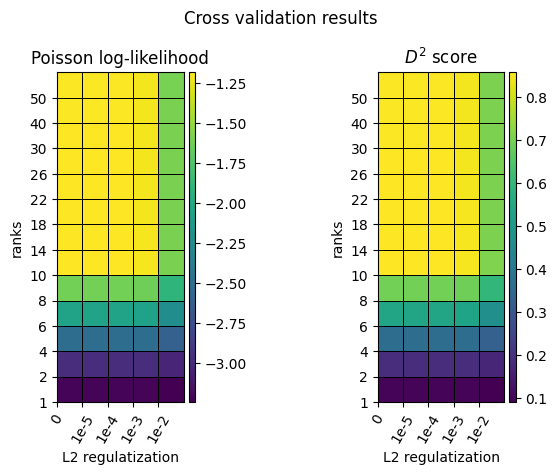

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)

PNLL_cv_mean = np.mean(PNLL_cv_2fold, axis=0)
rank_ix, reg_ix = np.unravel_index(np.argmax(-PNLL_cv_mean, axis=None), PNLL_cv_mean.shape)
print('Based on Poisson log-likelihood: best rank', ranks[rank_ix], 'best reg', regs[reg_ix])

im = ax1.pcolormesh(-PNLL_cv_mean, edgecolors='k', linewidth=0.5)
ax1.set_aspect('equal')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax1.set_title('Poisson log-likelihood')
ax1.set_xlabel('L2 regulatization')
ax1.set_xticks(np.arange(len(regs)))
ax1.set_xticklabels(['0', '1e-5', '1e-4', '1e-3', '1e-2'], rotation=60)
ax1.set_ylabel('ranks')
ax1.set_yticks(np.arange(len(ranks)))
ax1.set_yticklabels(ranks)

d2_cv_mean = np.mean(d2_cv_2fold, axis=0)
rank_ix, reg_ix = np.unravel_index(np.argmax(d2_cv_mean, axis=None), d2_cv_mean.shape)
print('Based on D2 score: best rank', ranks[rank_ix], 'best reg', regs[reg_ix])

im = ax2.pcolormesh(d2_cv_mean, edgecolors='k', linewidth=0.5)
ax2.set_aspect('equal')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax2.set_title(r'$D^2$ score')
ax2.set_xlabel('L2 regulatization')
ax2.set_xticks(np.arange(len(regs)))
ax2.set_xticklabels(['0', '1e-5', '1e-4', '1e-3', '1e-2'], rotation=60)
ax2.set_ylabel('ranks')
ax2.set_yticks(np.arange(len(ranks)))
ax2.set_yticklabels(ranks)

fig.suptitle('Cross validation results')
plt.tight_layout()
plt.show()



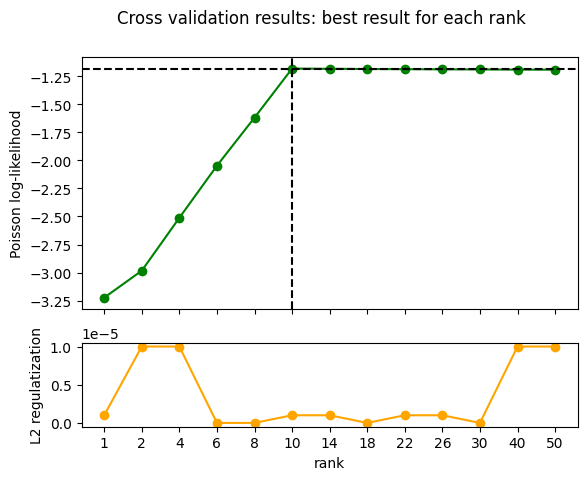

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[3, 1])
ax1.plot(np.max(-PNLL_cv_mean, axis=1), '-o', c='green')
ax1.axhline(y=np.max(-PNLL_cv_mean), linestyle='--', color='k')
ax1.axvline(x=np.argmax(np.max(-PNLL_cv_mean, axis=1)), linestyle='--', color='k')
ax1.set_ylabel('Poisson log-likelihood')

ax2.plot([regs[np.argmax(-PNLL_cv_mean[i])] for i in range(len(ranks))], '-o', c='orange')
ax2.set_ylabel('L2 regulatization')
ax2.set_xlabel('rank')
ax2.set_xticks(np.arange(len(ranks)))
ax2.set_xticklabels(ranks)

fig.suptitle('Cross validation results: best result for each rank')
plt.show()

Poisson-RRR successfully identifies the true rank of the weight!

# Compare to RRR

In [53]:
ranks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 22, 26, 30, 40, 50]
regs = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 1e+4]

In [54]:
mse_cv_2fold = np.zeros((2, len(ranks), len(regs)))

for l, reg in enumerate(regs):
    rrr0 = LinearRRR(bias=1, rank='max', regList=[reg], zeromeanY=0, normstdY=0, verbose=True)
    W_ols, vh = rrr0.fit([X_train1], Y_train1, [0], [0])
    for r, rank in enumerate(ranks):
        vh_r = vh[0:rank, :]
        weight = W_ols @ vh_r.T @ vh_r
        scores = rrr0.evaluate([X_val1], Y_val1, unnormY=1, weight=weight, metrics=['mse'])
        mse_cv_2fold[0, r, l] = scores['mse']
        
    rrr1 = LinearRRR(bias=1, rank='max', regList=[reg], zeromeanY=0, normstdY=0, verbose=True)
    W_ols, vh = rrr1.fit([X_val1], Y_val1, [0], [0])
    for r, rank in enumerate(ranks):
        vh_r = vh[0:rank, :]
        weight = W_ols @ vh_r.T @ vh_r
        scores = rrr1.evaluate([X_train1], Y_train1, unnormY=1, weight=weight, metrics=['mse'])
        mse_cv_2fold[1, r, l] = scores['mse']

Based on MSE: best rank 11 best reg 10


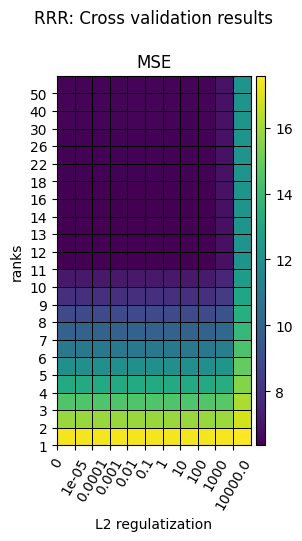

In [55]:
fig, ax = plt.subplots()

mse_cv_mean = np.mean(mse_cv_2fold, axis=0)
rank_ix, reg_ix = np.unravel_index(np.argmin(mse_cv_mean, axis=None), mse_cv_mean.shape)
print('Based on MSE: best rank', ranks[rank_ix], 'best reg', regs[reg_ix])

im = ax.pcolormesh(mse_cv_mean, edgecolors='k', linewidth=0.5)
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('MSE')
ax.set_xlabel('L2 regulatization')
ax.set_xticks(np.arange(len(regs)))
ax.set_xticklabels(regs, rotation=60)
ax.set_ylabel('ranks')
ax.set_yticks(np.arange(len(ranks)))
ax.set_yticklabels(ranks)
fig.text(0.5, 1, 'RRR: Cross validation results', fontsize='large',ha='center', va='center')
plt.show()

RRR rank will be one more than the true rank since one of them is the bias term.

Fit Poisson-RRR and RRR with their optimal ranks and regularizations on the whole training set and evaluate on the test set

In [56]:
best_pRRR = PoissonRRR(n_input=X1, n_output=Y1, act='softplus', rank=10, loss='poisson',
                  zeromeanXs=[0], normstdXs=[0], regList=[1e-6], seed=1)

In [57]:
start = time.time()
train_loss_hist, grad_hist = best_pRRR.train([X_train], Y_train, lr=1, maxepoch=50, max_iter=20,
                                          history_size=10, grad_tol=1e-4, line_search=1,
                                          shuffle=True, track=1, patience=10, loss_tol=1e-6, progfile=None)
end = time.time()
print('elapsed {:.4f}s'.format(end-start))

train: cpu
epoch 0: training loss 
 5.392459869384766
epoch 1: training loss 1.1957919597625732
          gradient [0.00201579 0.00292867 0.0037835  0.00191451]
epoch 2: training loss 1.1793807744979858
          gradient [3.0235640e-05 6.1758896e-05 5.6457549e-05 1.0205530e-04]
gradient less than 0.0001 after 3 epochs 
 
epoch 3: training loss 1.1793549060821533
          gradient [7.0655965e-06 7.3481115e-06 1.1486175e-05 1.2989025e-05]
final train loss 1.179355 grad [7.0655965e-06 7.3481115e-06 1.1486175e-05 1.2989025e-05] 

elapsed 1.0515s


In [58]:
train_scores_pRRR, Y_train_pred_pRRR = best_pRRR.eval([X_train], Y_train, metrics=['PNLL', 'cc', 'r2', 'd2', 'MSE'])
test_scores_pRRR, Y_test_pred_pRRR = best_pRRR.eval([X_test], Y_test, metrics=['PNLL', 'cc', 'r2', 'd2', 'MSE'])

cpu
cpu


In [59]:
best_rrr = LinearRRR(bias=1, rank=11, regList=[10], zeromeanY=0, normstdY=0, verbose=False)
best_rrr.fit([X_train], Y_train, [0], [0])

In [60]:
train_scores_rrr = best_rrr.evaluate([X_train], Y_train, metrics=['mse', 'r2', 'd2'])
test_scores_rrr = best_rrr.evaluate([X_test], Y_test, metrics=['mse', 'r2', 'd2'])

In [61]:
Y_train_pred_rrr = best_rrr.predict([X_train])
Y_test_pred_rrr = best_rrr.predict([X_test])

In [62]:
# compute the likelihood, mse, r2, d2 with the true mean generating the observations
train_scores_true, test_scores_true = {}, {}
loss_func = nn.PoissonNLLLoss(log_input=False, full=True, reduction='mean')
train_scores_true['PNLL'] = loss_func(Y_mean[:int(X0*0.8)], torch.from_numpy(Y_train).float()).item()
test_scores_true['PNLL'] = loss_func(Y_mean[int(X0*0.8):], torch.from_numpy(Y_test).float()).item()

train_scores_true['d2raw'] = np.array([sklearn.metrics.d2_tweedie_score(Y_train[:, i], Y_mean[:int(X0*0.8), i], power=1) for i in range(Y1)])
test_scores_true['d2raw'] = np.array([sklearn.metrics.d2_tweedie_score(Y_test[:, i], Y_mean[int(X0*0.8):, i], power=1) for i in range(Y1)])

train_scores_true['d2uniform'] = np.average(train_scores_true['d2raw'])
test_scores_true['d2uniform'] = np.average(test_scores_true['d2raw'])

train_scores_true['mse'] = sklearn.metrics.mean_squared_error(Y_train, Y_mean[:int(X0*0.8)])
test_scores_true['mse'] = sklearn.metrics.mean_squared_error(Y_test, Y_mean[int(X0*0.8):])

train_scores_true['r2uniform'] = sklearn.metrics.r2_score(Y_train, Y_mean[:int(X0*0.8)], multioutput='uniform_average')
test_scores_true['r2uniform'] = sklearn.metrics.r2_score(Y_test, Y_mean[int(X0*0.8):], multioutput='uniform_average')

In [63]:
# also compute log-likelihood for RRR and MSE for Poisson-RRR
train_scores_rrr['PNLL'] = loss_func(torch.from_numpy(np.clip(Y_train_pred_rrr, a_min=0, a_max=None)).float(), torch.from_numpy(Y_train).float()).item()
test_scores_rrr['PNLL'] = loss_func(torch.from_numpy(np.clip(Y_test_pred_rrr, a_min=0, a_max=None)).float(), torch.from_numpy(Y_test).float()).item()


In [64]:
heads = ['Training set', 'Poisson log-likelihood', 'MSE', 'D2 score', 'R2 score']
train_table = [['true mean', -train_scores_true['PNLL'], train_scores_true['mse'], train_scores_true['d2uniform'], train_scores_true['r2uniform']], 
         ['Poisson-RRR', -train_scores_pRRR['PNLL'], train_scores_pRRR['MSE'], train_scores_pRRR['d2uniform'], train_scores_pRRR['r2uniform']],
         ['RRR', -train_scores_rrr['PNLL'], train_scores_rrr['mse'], train_scores_rrr['d2uniform'], train_scores_rrr['r2uniform']]]
print(tabulate(train_table, headers=heads, tablefmt='grid'))

+----------------+--------------------------+---------+------------+------------+
| Training set   |   Poisson log-likelihood |     MSE |   D2 score |   R2 score |
+================+==========================+=========+============+============+
| true mean      |                 -1.17902 | 2.80131 |   0.858704 |   0.82711  |
+----------------+--------------------------+---------+------------+------------+
| Poisson-RRR    |                 -1.1772  | 2.7898  |   0.859401 |   0.827821 |
+----------------+--------------------------+---------+------------+------------+
| RRR            |                 -1.60251 | 6.26638 |   0.697233 |   0.634695 |
+----------------+--------------------------+---------+------------+------------+


(Poisson log-likehood and $D^2$ score for RRR is computed by setting the negative entries in RRR prediction to zero.)

In [65]:
heads = ['Test set', 'Poisson log-likelihood', 'MSE', 'D2 score', 'R2 score']
test_table = [['true mean', -test_scores_true['PNLL'], test_scores_true['mse'], test_scores_true['d2uniform'], test_scores_true['r2uniform']], 
         ['Poisson-RRR', -test_scores_pRRR['PNLL'], test_scores_pRRR['MSE'], test_scores_pRRR['d2uniform'], test_scores_pRRR['r2uniform']],
         ['RRR', -test_scores_rrr['PNLL'], test_scores_rrr['mse'], test_scores_rrr['d2uniform'], test_scores_rrr['r2uniform']]]
print(tabulate(test_table, headers=heads, tablefmt='grid'))

+-------------+--------------------------+---------+------------+------------+
| Test set    |   Poisson log-likelihood |     MSE |   D2 score |   R2 score |
+=============+==========================+=========+============+============+
| true mean   |                 -1.17622 | 2.78444 |   0.857843 |   0.827361 |
+-------------+--------------------------+---------+------------+------------+
| Poisson-RRR |                 -1.17802 | 2.79712 |   0.857149 |   0.826627 |
+-------------+--------------------------+---------+------------+------------+
| RRR         |                 -1.60814 | 6.35509 |   0.69266  |   0.628796 |
+-------------+--------------------------+---------+------------+------------+


Latent factor recovery

In [66]:
u_true, s_true, vh_true = np.linalg.svd(W, full_matrices=False)
print(u_true.shape, s_true.shape, vh_true.shape)

(100, 50) (50,) (50, 50)


In [67]:
W_pRRR = (best_pRRR.glm.state_dict()['linear2.weight'].detach().numpy() @ best_pRRR.glm.state_dict()['linear1.weight'].detach().numpy()).transpose()

In [68]:
u_pRRR, s_pRRR, vh_pRRR = np.linalg.svd(W_pRRR, full_matrices=False)

In [69]:
u_rrr, s_rrr, vh_rrr = np.linalg.svd(best_rrr.weight[1:], full_matrices=False)

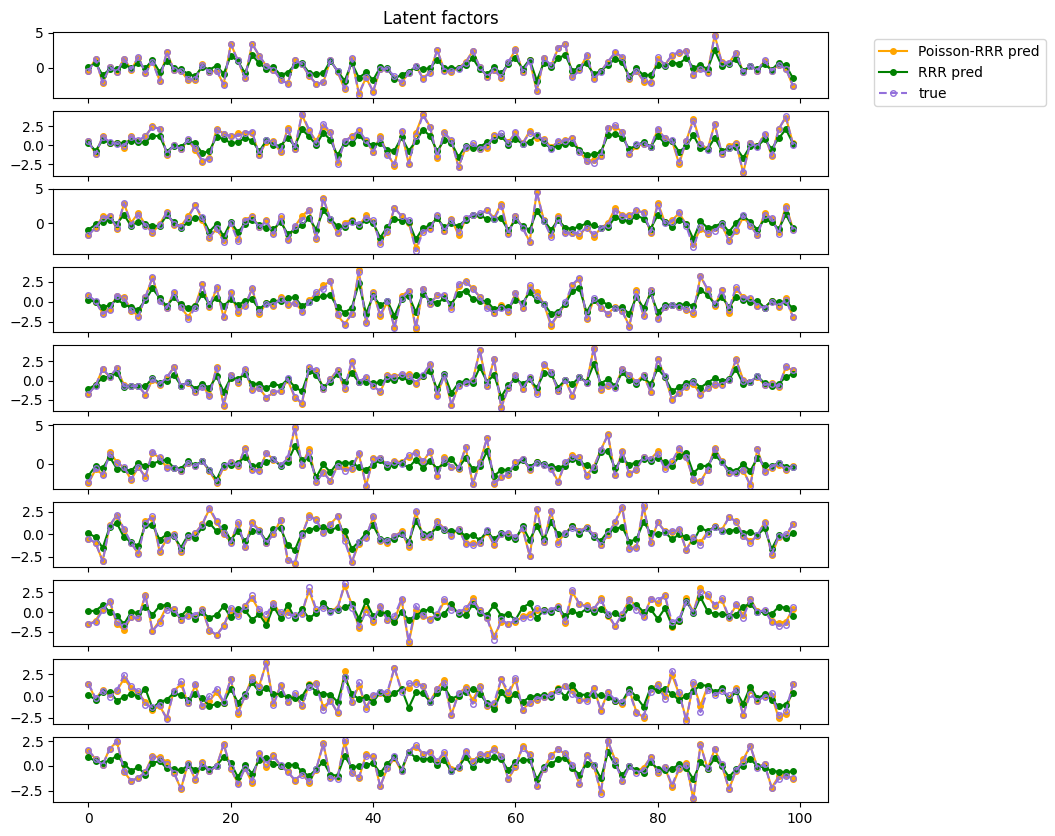

In [70]:
fig, axes = plt.subplots(10, 1, sharex=True, figsize=(10, 10))
sim_table = [['PoissonRRR'], ['RRR']]
for i in range(10):
    ang = np.dot(u_true[:,i], u_pRRR[:,i])/(np.linalg.norm(u_true[:,i])*np.linalg.norm(u_pRRR[:,i]))
    sim_table[0].append('{:.4f}'.format(abs(ang)))
    if ang > 0:
        axes[i].plot(u_pRRR[:,i]*s_pRRR[i], '-o', c='orange', markersize=4, label='Poisson-RRR pred')
    else:
        axes[i].plot(-u_pRRR[:,i]*s_pRRR[i], '-o', c='orange', markersize=4, label='Poisson-RRR pred')
        
    ang = np.dot(u_true[:,i], u_rrr[:,i])/(np.linalg.norm(u_true[:,i])*np.linalg.norm(u_rrr[:,i]))
    sim_table[1].append('{:.4f}'.format(abs(ang)))
    if ang > 0:
        axes[i].plot(u_rrr[:,i]*s_rrr[i], '-o', c='green', markersize=4, label='RRR pred')
    else:
        axes[i].plot(-u_rrr[:,i]*s_rrr[i], '-o', c='green', markersize=4, label='RRR pred')
    axes[i].plot(u_true[:,i]*s_true[i], '--o', c='mediumpurple', markersize=4, markerfacecolor='None', label='true')

axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[0].set_title('Latent factors')
plt.show()

In [71]:
heads = ['cosine similarity']
for i in range(10):
    heads.append('PC{}'.format(i+1))
print(tabulate(sim_table, headers=heads, tablefmt='grid'))

+---------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| cosine similarity   |    PC1 |    PC2 |    PC3 |    PC4 |    PC5 |    PC6 |    PC7 |    PC8 |    PC9 |   PC10 |
+=====================+========+========+========+========+========+========+========+========+========+========+
| PoissonRRR          | 0.9988 | 0.9946 | 0.9902 | 0.9939 | 0.9982 | 0.9962 | 0.9961 | 0.9805 | 0.9823 | 0.9961 |
+---------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| RRR                 | 0.9489 | 0.9589 | 0.9281 | 0.9442 | 0.9411 | 0.8313 | 0.8539 | 0.2368 | 0.4575 | 0.8868 |
+---------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+


Test set prediction

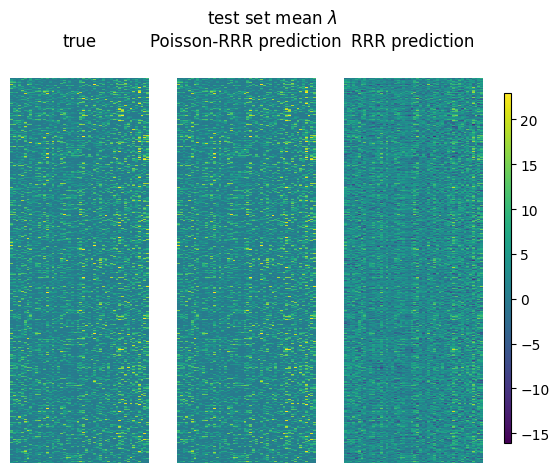

In [72]:
fig, axes =  plt.subplots(1, 3, figsize=(7, 5))
fig.text(0.5, 1, r'test set mean $\lambda$', ha='center', va='center', fontsize='large')

vmin=min(np.min(Y_mean.numpy()[int(X0*0.8):]), np.min(Y_test_pred_pRRR), np.min(Y_test_pred_rrr))
vmax=min(np.max(Y_mean.numpy()[int(X0*0.8):]), np.max(Y_test_pred_pRRR), np.max(Y_test_pred_rrr))

im = axes[0].matshow(Y_mean.numpy()[int(X0*0.8):], aspect='auto', vmin=vmin, vmax=vmax)
axes[0].axis('off')
axes[0].set_title('true')

im = axes[1].matshow(Y_test_pred_pRRR, aspect='auto', vmin=vmin, vmax=vmax)
axes[1].axis('off')
axes[1].set_title('Poisson-RRR prediction')

im = axes[2].matshow(Y_test_pred_rrr, aspect='auto', vmin=vmin, vmax=vmax)
axes[2].axis('off')
axes[2].set_title('RRR prediction')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

# plt.tight_layout()
plt.show()